<div style="text-align: justify">
<font size=6><br><h2 align="center">Detección de las conductas distractoras al conducir un automóvil </h2></font>
<font size=5><br>
<h3 align="center">Inteligencia Artificial II</h3></font><font size=5>
<h3 align="center">Proyecto Final</h3></font> 
    
<br/>

<font size=5><h4 align="left">Intregrantes: </h4></font>      
2172016 - Kevin Javier Lozano Galvis<br><br>
2170688 - Brayan Rodolfo Barajas Ochoa<br>

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from skimage import color
import matplotlib.pyplot as plt
from dask.array.image import imread
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=57e0d813a7ae5c0c1c1b455dc7e83ba336220856ac9419f55c7779eceea8c235
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinlozanogalvis","key":"7aa893581a3e3a99473c2eda021232eb"}'}

In [4]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Mar  8 01:12 kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!kaggle competitions download -c state-farm-distracted-driver-detection -p imgs

100% 3.99G/4.00G [01:12<00:00, 111MB/s]
100% 4.00G/4.00G [01:13<00:00, 58.8MB/s]


In [8]:
cd imgs

[Errno 2] No such file or directory: 'imgs'
/content/imgs


In [9]:
!unzip state-farm-distracted-driver-detection.zip -d /content

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/imgs/train/c7/img_56636.jpg  
  inflating: /content/imgs/train/c7/img_56661.jpg  
  inflating: /content/imgs/train/c7/img_56699.jpg  
  inflating: /content/imgs/train/c7/img_56717.jpg  
  inflating: /content/imgs/train/c7/img_56724.jpg  
  inflating: /content/imgs/train/c7/img_56768.jpg  
  inflating: /content/imgs/train/c7/img_56779.jpg  
  inflating: /content/imgs/train/c7/img_56849.jpg  
  inflating: /content/imgs/train/c7/img_56899.jpg  
  inflating: /content/imgs/train/c7/img_56938.jpg  
  inflating: /content/imgs/train/c7/img_5706.jpg  
  inflating: /content/imgs/train/c7/img_57076.jpg  
  inflating: /content/imgs/train/c7/img_57122.jpg  
  inflating: /content/imgs/train/c7/img_57137.jpg  
  inflating: /content/imgs/train/c7/img_5715.jpg  
  inflating: /content/imgs/train/c7/img_57278.jpg  
  inflating: /content/imgs/train/c7/img_57321.jpg  
  inflating: /content/imgs/train/c7/img_57345.jpg  
  inf

In [10]:
%pwd

'/content/imgs'

In [11]:
!rm state-farm-distracted-driver-detection.zip

In [12]:
%ls /content

driver_imgs_list.csv  imgs/  kaggle.json  sample_data/  sample_submission.csv


In [13]:
df = pd.read_csv("../driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


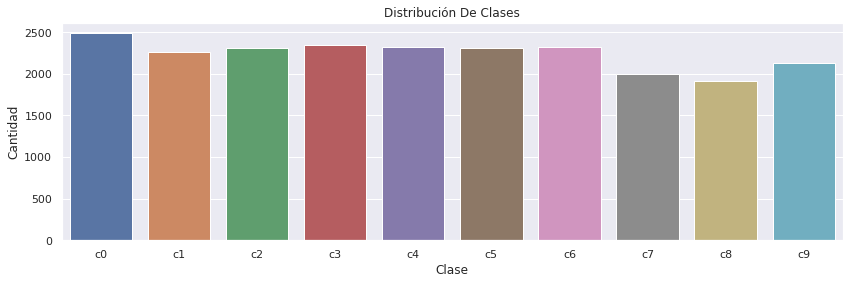

In [14]:
sns.set()
plt.figure(figsize = (14,4))
sns.countplot(x = 'classname',data = df)
plt.title('Distribución de Clases'.title())
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.show()

In [15]:
categor = {'c0': 'Safe driving', 
           'c1': 'Texting - right', 
           'c2': 'Talking on the phone - right', 
           'c3': 'Texting - left', 
           'c4': 'Talking on the phone - left', 
           'c5': 'Operating the radio', 
           'c6': 'Drinking', 
           'c7': 'Reaching behind', 
           'c8': 'Hair and makeup', 
           'c9': 'Talking to passenger'}

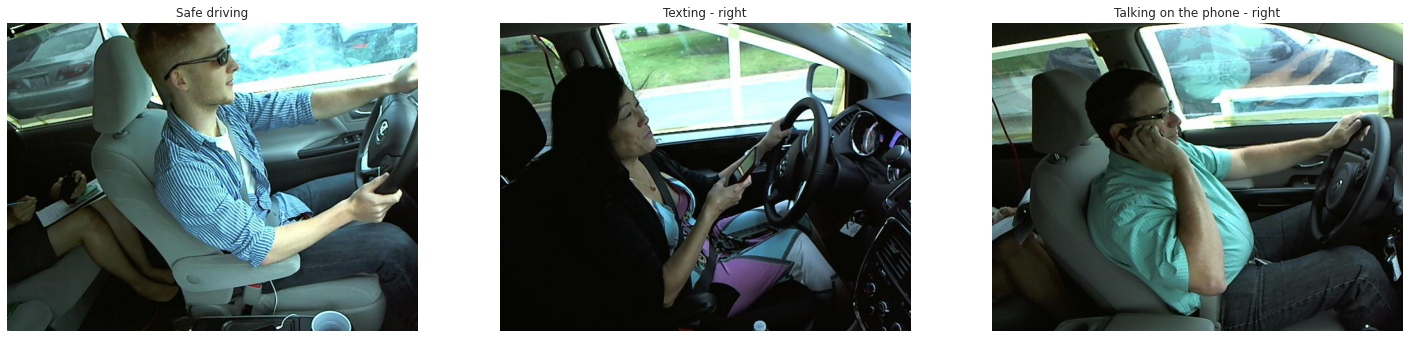

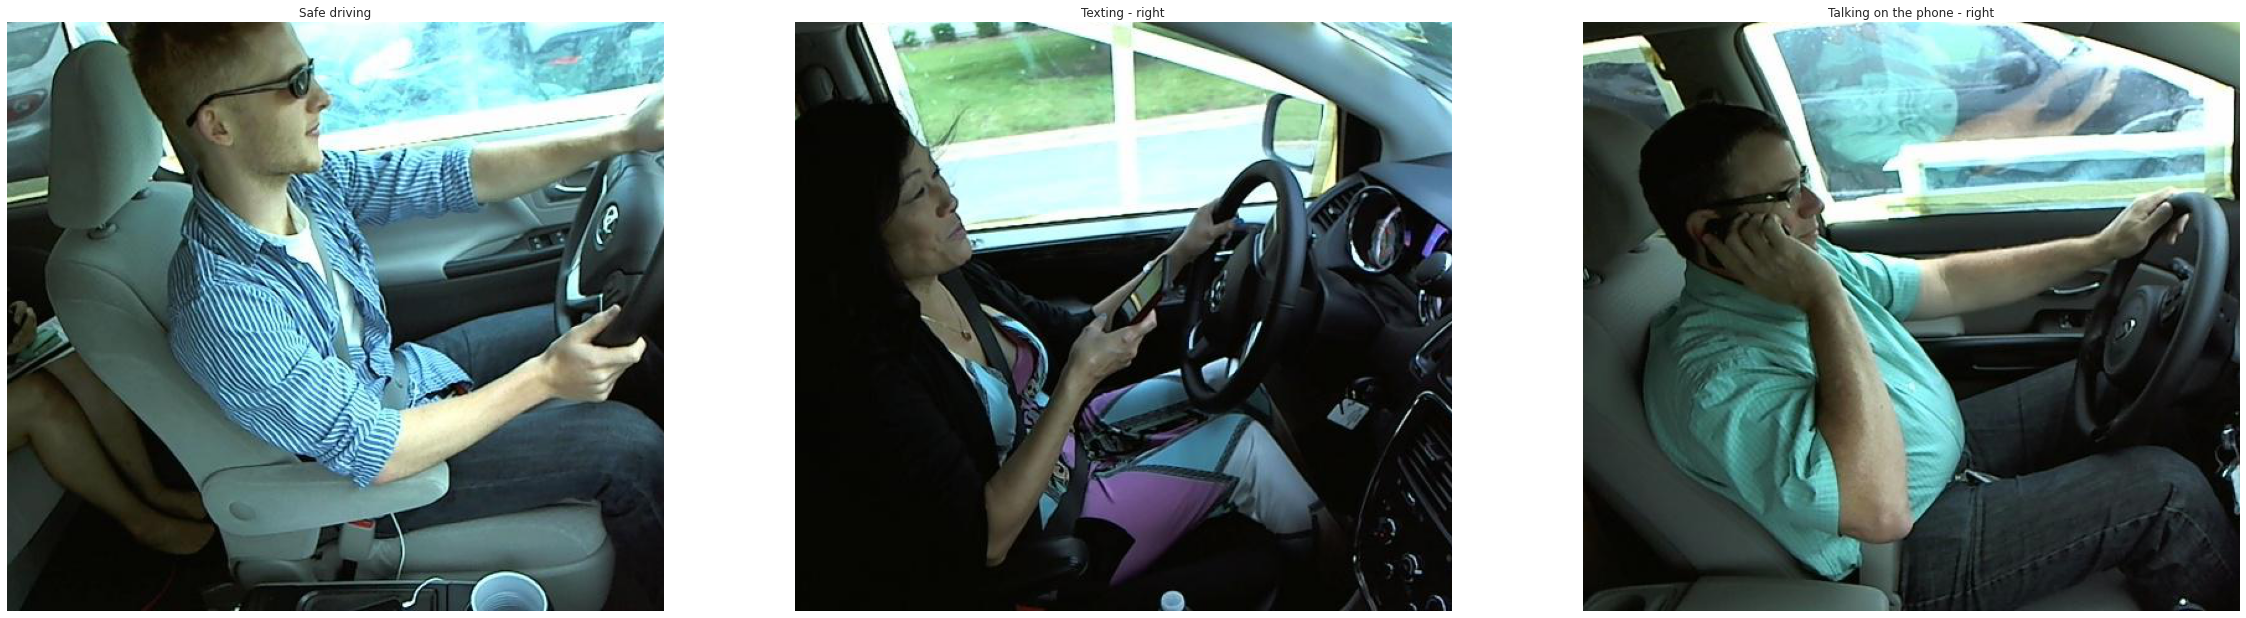

In [16]:
# Imágenes del dataset
f, ax = plt.subplots(1,3, figsize = (25,25))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

# Algunos ejemplos de como van a quedar las imágenes 
f, ax = plt.subplots(1,3, figsize = (40,40))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        img = img[5:,100:-10]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

# Procesamiento de Datos

In [17]:
driver_details = pd.read_csv('/content/driver_imgs_list.csv',na_values='na')
driver_details.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [19]:
train_image = []
image_label = []

for i in range(10):
    print('Class C',i)
    imgs = os.listdir("/content/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[5:,100:-10]
        img = cv2.resize(img,(128,128))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

Class C 0
Class C 1
Class C 2
Class C 3
Class C 4
Class C 5
Class C 6
Class C 7
Class C 8
Class C 9


In [20]:
random.shuffle(train_image)

In [21]:
D = []
for features,labels,drivers in train_image:
    D.append(drivers)

In [22]:
deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)

In [23]:
driv_selected = []
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])

In [24]:
X_train= []; y_train = []; X_test = []; y_test = []; D_train = []; D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

19093 3331
19093 3331


In [25]:
X_train = np.array(X_train).reshape(-1,128,128,3)
X_test = np.array(X_test).reshape(-1,128,128,3)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print (X_train.shape)

(19093, 128, 128, 3)


# Modelo Creado CNN 

In [ ]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (128 , 128 , 1), activation = 'relu',  kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(128, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

In [ ]:
model_CNN.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(lr = 0.01) , metrics = 'accuracy')
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 128)     3328      
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 128)     512       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 85, 85, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 85, 85, 64)        204864    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        51232     
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 32)       

In [ ]:
history = model_CNN.fit(X_train , y_train, epochs = 20, batch_size=64, validation_data=(X_test, y_test)) 

Epoch 1/20
294/294 [==============================] - 18s 61ms/step - loss: 2.7751 - accuracy: 0.1290 - val_loss: 2.2355 - val_accuracy: 0.1811
Epoch 2/20
294/294 [==============================] - 17s 59ms/step - loss: 2.1325 - accuracy: 0.2164 - val_loss: 2.0213 - val_accuracy: 0.2826
Epoch 3/20
294/294 [==============================] - 17s 59ms/step - loss: 1.7055 - accuracy: 0.3963 - val_loss: 1.9092 - val_accuracy: 0.4154
Epoch 4/20
294/294 [==============================] - 17s 59ms/step - loss: 1.2052 - accuracy: 0.5860 - val_loss: 1.9133 - val_accuracy: 0.4409
Epoch 5/20
294/294 [==============================] - 17s 59ms/step - loss: 0.8661 - accuracy: 0.7128 - val_loss: 1.9335 - val_accuracy: 0.4647
Epoch 6/20
294/294 [==============================] - 17s 59ms/step - loss: 0.5914 - accuracy: 0.8068 - val_loss: 1.9150 - val_accuracy: 0.4711
Epoch 7/20
294/294 [==============================] - 17s 59ms/step - loss: 0.4531 - accuracy: 0.8545 - val_loss: 2.0015 - val_accuracy:

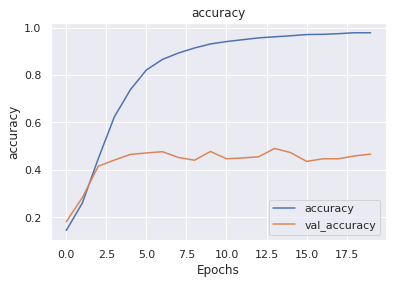

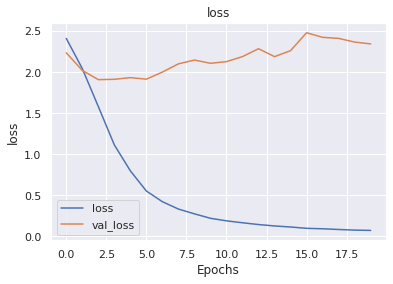

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Transfer Learning con VGG16 

In [26]:
model_VGG16 =  tf.keras.applications.VGG16(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG16.trainable = True
print("Total layers of VGG16: ", len(model_VGG16.layers))
#set_trainable = False

#for layer in model_VGG16.layers:
  #if layer.name == 'block5_conv2':
    #set_trainable = True
  #if layer.name == 'block5_conv3':
    #set_trainable = True
  #if set_trainable: 
    #layer.trainable = True
  #else:
    #layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step
Total layers of VGG16:  19


In [27]:
for layer in model_VGG16.layers[:8]:
  layer.trainable =  False

model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [28]:
model_cnn_VGG16 = tf.keras.models.Sequential([
    model_VGG16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 14,977,194
Trainable params: 14,421,866
Non-trainable params: 555,328
_________________________________________________________________


In [ ]:
learning_rate= 0.0001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16.fit(X_train, y_train , epochs=15,verbose=1, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
295/295 [==============================] - 91s 189ms/step - loss: 2.5529 - accuracy: 0.1880 - val_loss: 1.8271 - val_accuracy: 0.3767
Epoch 2/15
295/295 [==============================] - 52s 177ms/step - loss: 1.2160 - accuracy: 0.6285 - val_loss: 1.4203 - val_accuracy: 0.5480
Epoch 3/15
295/295 [==============================] - 52s 177ms/step - loss: 0.6678 - accuracy: 0.8348 - val_loss: 1.1940 - val_accuracy: 0.6503
Epoch 4/15
295/295 [==============================] - 52s 177ms/step - loss: 0.4282 - accuracy: 0.9042 - val_loss: 1.0652 - val_accuracy: 0.6913
Epoch 5/15
295/295 [==============================] - 52s 177ms/step - loss: 0.2997 - accuracy: 0.9376 - val_loss: 0.9903 - val_accuracy: 0.7119
Epoch 6/15
295/295 [==============================] - 52s 177ms/step - loss: 0.2279 - accuracy: 0.9539 - val_loss: 0.9349 - val_accuracy: 0.7306
Epoch 7/15
295/295 [==============================] - 52s 177ms/step - loss: 0.1789 - accuracy: 0.9667 - val_loss: 0.8959 - val_ac

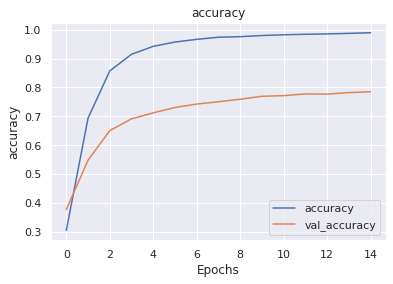

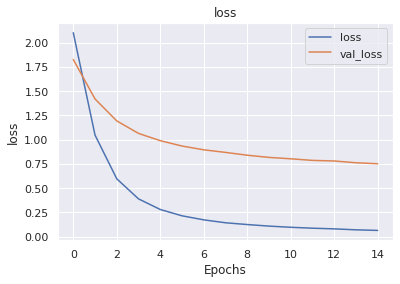

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG16.evaluate(X_test, y_test, verbose = 1)

113/113 [==============================] - 11s 71ms/step - loss: 0.7523 - accuracy: 0.7850


# Transfer Learning VGG16 con Data Augmentation

In [30]:
datagen = ImageDataGenerator(width_shift_range=0.5, height_shift_range=0.5, zoom_range = 0.5, rotation_range=30)
datagen.fit(X_train)

In [31]:
training = datagen.flow(X_train, y_train, batch_size=128)

In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/VGG1_weights.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [33]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 30, verbose=1,validation_data=(X_test, y_test))

Epoch 1/30
149/149 [==============================] - 114s 536ms/step - loss: 3.2722 - accuracy: 0.1058 - val_loss: 2.3350 - val_accuracy: 0.0708

Epoch 00001: val_loss improved from inf to 2.33499, saving model to Models/VGG1_weights.hdf5
Epoch 2/30
149/149 [==============================] - 78s 523ms/step - loss: 2.2979 - accuracy: 0.1165 - val_loss: 2.2958 - val_accuracy: 0.1564

Epoch 00002: val_loss improved from 2.33499 to 2.29576, saving model to Models/VGG1_weights.hdf5
Epoch 3/30
149/149 [==============================] - 77s 518ms/step - loss: 2.2672 - accuracy: 0.1477 - val_loss: 2.2564 - val_accuracy: 0.1504

Epoch 00003: val_loss improved from 2.29576 to 2.25642, saving model to Models/VGG1_weights.hdf5
Epoch 4/30
149/149 [==============================] - 77s 519ms/step - loss: 2.2309 - accuracy: 0.1628 - val_loss: 2.1598 - val_accuracy: 0.2056

Epoch 00004: val_loss improved from 2.25642 to 2.15976, saving model to Models/VGG1_weights.hdf5
Epoch 5/30
149/149 [===========

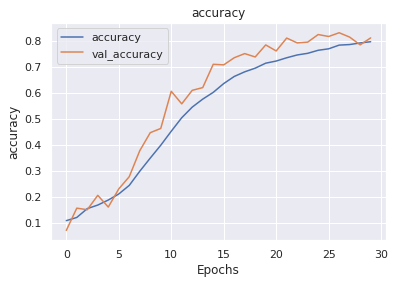

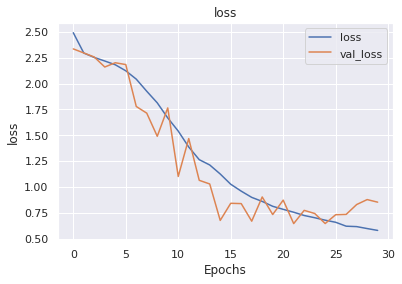

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG16.evaluate(X_test, y_test, verbose = 1)

# VGG19

In [58]:
model_VGG19 =  tf.keras.applications.VGG19(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG19.trainable = True
print("Total layers of VGG16: ", len(model_VGG19.layers))

Total layers of VGG16:  22


In [59]:
for layer in model_VGG19.layers[:8]:
  layer.trainable =  False

model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [60]:
model_cnn_VGG19 = tf.keras.models.Sequential([
    model_VGG19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG19.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 20,286,890
Trainable params: 19,731,562
Non-trainable params: 555,328
_________________________________________________________________


In [61]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/VGG192_weights.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [42]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG19.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG19.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

Epoch 1/30
149/149 [==============================] - 80s 528ms/step - loss: 3.0763 - accuracy: 0.1048 - val_loss: 2.3104 - val_accuracy: 0.1153

Epoch 00001: val_loss improved from inf to 2.31042, saving model to Models/VGG19_weights.hdf5
Epoch 2/30
149/149 [==============================] - 79s 528ms/step - loss: 2.2935 - accuracy: 0.1284 - val_loss: 2.2681 - val_accuracy: 0.1264

Epoch 00002: val_loss improved from 2.31042 to 2.26807, saving model to Models/VGG19_weights.hdf5
Epoch 3/30
149/149 [==============================] - 78s 524ms/step - loss: 2.2683 - accuracy: 0.1446 - val_loss: 2.1674 - val_accuracy: 0.1834

Epoch 00003: val_loss improved from 2.26807 to 2.16744, saving model to Models/VGG19_weights.hdf5
Epoch 4/30
149/149 [==============================] - 78s 523ms/step - loss: 2.2192 - accuracy: 0.1677 - val_loss: 2.0914 - val_accuracy: 0.2249

Epoch 00004: val_loss improved from 2.16744 to 2.09142, saving model to Models/VGG19_weights.hdf5
Epoch 5/30
149/149 [========

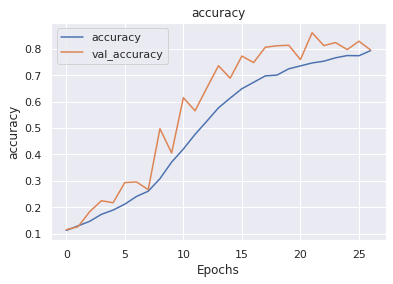

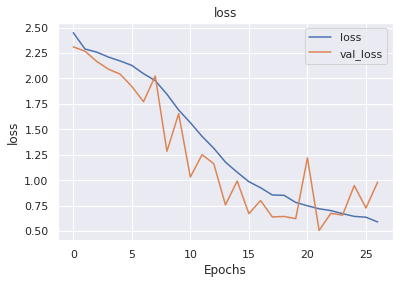

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [44]:
validation_loss, validation_acc = model_cnn_VGG19.evaluate(X_test, y_test, verbose = 1)

105/105 [==============================] - 3s 25ms/step - loss: 0.9810 - accuracy: 0.7953


# Densenet

In [ ]:
model_VGG19 =  tf.keras.applications.VGG19(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG19.trainable = True
print("Total layers of VGG16: ", len(model_VGG19.layers))